# 3D Keypoint Visualizatino in 3D view

In this example, we visualize 3D body/face/hands in 3D space

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

# For camera projection (with distortion)
import panutils

In [2]:
# Setup paths
data_path = '../'
seq_name = '171204_pose1_sample'

hd_skel_json_path = data_path+seq_name+'/hdPose3d_stage1_coco19/'
hd_face_json_path = data_path+seq_name+'/hdFace3d/'
hd_hand_json_path = data_path+seq_name+'/hdHand3d/'
#hd_img_path = data_path+seq_name+'/hdImgs/'

colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()


## Load camera calibration parameters (for visualizing cameras)

In [3]:
# Load camera calibration parameters (for visualizing cameras)
with open(data_path+seq_name+'/calibration_{0}.json'.format(seq_name)) as cfile:
    calib = json.load(cfile)

# Cameras are identified by a tuple of (panel#,node#)
cameras = {(cam['panel'],cam['node']):cam for cam in calib['cameras']}

# Convert data into numpy arrays for convenience
for k,cam in cameras.iteritems():    
    cam['K'] = np.matrix(cam['K'])
    cam['distCoef'] = np.array(cam['distCoef'])
    cam['R'] = np.matrix(cam['R'])
    cam['t'] = np.array(cam['t']).reshape((3,1))

    
# Choose only HD cameras for visualization
hd_cam_idx = zip([0] * 30,range(0,30))
hd_cameras = [cameras[cam].copy() for cam in hd_cam_idx]




## Select Image Frame

In [4]:
# Select HD Image index
hd_idx = 400

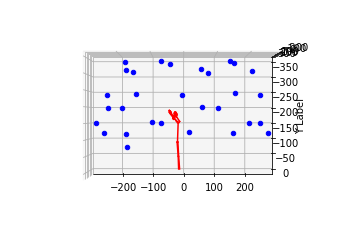

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = -90, azim=-90)
#ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
ax.axis('equal')

# Draw selected camera subset in blue
for cam in hd_cameras:
    cc = (-cam['R'].transpose()*cam['t'])
    ax.scatter(cc[0], cc[1], cc[2], '.', color=[0,0,1])
    
'''
## Visualize 3D Body
'''
# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1

try:
    # Load the json file with this frame's skeletons
    skel_json_fname = hd_skel_json_path+'body3DScene_{0:08d}.json'.format(hd_idx)
    with open(skel_json_fname) as dfile:
        bframe = json.load(dfile)

    # Bodies
    for ids in xrange(len(bframe['bodies'])):
        body = bframe['bodies'][ids]
        skel = np.array(body['joints19']).reshape((-1,4)).transpose()

        for edge in body_edges:
            ax.plot(skel[0,edge], skel[1,edge], skel[2,edge], color=colors[body['id']])
            
except IOError as e:
    print('Error reading {0}\n'.format(skel_json_fname)+e.strerror)
    
'''
## Visualize 3D Face
'''
# Face keypoint orders follow Openpose keypoint output
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md
# Face outline points (0-16) are unstable
face_edges = np.array([ #[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[11,12],[12,13],[14,15],[15,16], #outline (ignored)
                [17,18],[18,19],[19,20],[20,21], #right eyebrow
                [22,23],[23,24],[24,25],[25,26], #left eyebrow
                [27,28],[28,29],[29,30],   #nose upper part
                [31,32],[32,33],[33,34],[34,35], #nose lower part
                [36,37],[37,38],[38,39],[39,40],[40,41],[41,36], #right eye
                [42,43],[43,44],[44,45],[45,46],[46,47],[47,42], #left eye
                [48,49],[49,50],[50,51],[51,52],[52,53],[53,54],[54,55],[55,56],[56,57],[57,58],[58,59],[59,48], #Lip outline
                [60,61],[61,62],[62,63],[63,64],[64,65],[65,66],[66,67],[67,60] #Lip inner line 
                ])

# Load the json file with this frame's face
try:
    face_json_fname = hd_face_json_path+'faceRecon3D_hd{0:08d}.json'.format(hd_idx)
    with open(face_json_fname) as dfile:
        fframe = json.load(dfile)

    # Cycle through all detected faces
    for face in fframe['people']:
        
        # 3D Face has 70 3D joints, stored as an array [x1,y1,z1,x2,y2,z2,...]
        face3d = np.array(face['face70']['landmarks']).reshape((-1,3)).transpose()

        # Plot edges for each bone
        for edge in face_edges:
            ax.plot(face3d[0,edge], face3d[1,edge], face3d[2,edge], color=colors[face['id']])

except IOError as e:
    print('Error reading {0}\n'.format(face_json_fname)+e.strerror)


'''
## Visualize 3D Hand
'''
# Joint orders follow Openpose keypoint output
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md
hand_edges = np.array([[0,1],[1,2],[2,3],[3,4],
                [0,5],[5,6],[6,7],[7,8],
                [0,9],[9,10],[10,11],[11,12],
                [0,13],[13,14],[14,15],[15,16],
                [0,17],[17,18],[18,19],[19,20]])
try:
    # Load the json file with this frame's face
    hand_json_fname = hd_hand_json_path+'handRecon3D_hd{0:08d}.json'.format(hd_idx)
    with open(hand_json_fname) as dfile:
        hframe = json.load(dfile)

    # Cycle through all detected hands
    for hand in hframe['people']:
        
        # 3D hands, right_hand and left_hand, have 21 3D joints, stored as an array [x1,y1,z1,x2,y2,z2,...]

        '''
        # Right hand
        '''
        hand3d = np.array(hand['right_hand']['landmarks']).reshape((-1,3)).transpose()

        # Plot edges for each bone
        for edge in hand_edges:
            ax.plot(hand3d[0,edge], hand3d[1,edge], hand3d[2,edge], color=colors[hand['id']])

        '''
        # Left hand
        '''
        hand3d = np.array(hand['left_hand']['landmarks']).reshape((-1,3)).transpose()

        # Plot edges for each bone
        for edge in hand_edges:
            ax.plot(hand3d[0,edge], hand3d[1,edge], hand3d[2,edge], color=colors[hand['id']])

except IOError as e:
    print('Error reading {0}\n'.format(hand_json_fname)+e.strerror)


    
plt.show()